# Executive Summary

This project aims to build a univariate time series forecasting model for Square stock price in next 24 months from Jan 2021.

Data is acquired from Yahoo Finance, containing historical stock price of Square and this is pre-processed to standardise time format and check for data quality issues. Time series decomposition is done to find useful information on autocorrelation and partial correlation. In the end, ARIMA and Holt Winters model are built and the model with the best cross validation performance is chosen for forecasting. In conclusion, ARIMA model (3,1,2) has the best performance and we can expect Square price to raise to $600 in 2 years time.

# 1. Data Acquisition

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from scipy import stats

import forecast

import warnings
warnings.filterwarnings("ignore")

In [2]:
square_raw_data = pd.read_csv('square_raw_data.csv', index_col = 'Date', parse_dates=True)

In [3]:
square_raw_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-01,166.139999,193.440002,152.429993,154.880005,154.880005,170582800
2020-11-01,158.000000,215.000000,151.100006,210.960007,210.960007,227838900
2020-12-01,212.559998,243.380005,195.130005,217.639999,217.639999,199124200
2021-01-01,222.494995,225.979996,216.000000,221.160004,221.160004,9823900
2021-01-04,222.494995,225.979996,216.000000,221.160004,221.160004,9664977


In [4]:
square_raw_data.index

DatetimeIndex(['2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01',
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
      

# 2. Data Pre-processing

### 2.1 Keep date and closing price

In [5]:
square_price = square_raw_data[['Close']].head(len(square_raw_data)-1)

In [6]:
square_price

,Close
Date,
2015-11-01,12.040000
2015-12-01,13.090000
2016-01-01,8.770000
2016-02-01,10.440000
2016-03-01,15.280000
...,...
2020-09-01,162.550003
2020-10-01,154.880005
2020-11-01,210.960007


### 2.3 Check for null values

In [7]:
square_cleaned_data = square_price
square_cleaned_data.isnull().sum()

Close    0
dtype: int64

There is no null values in dataset

# 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [8]:
def summary_stats(df):
    summary_statistics = []
    statistics_columns = ["Mean", "Median", "Standard Deviation", 
                          "Sample Variance","Kurtosis", 
                          "Skewness", "Range", "Minimum", 
                          "Maximum", "Sum", "Count"] # measures of statistics
    selected_cols = []
    for column in df:
        if df[column].dtype == np.float64 or df[column].dtype == np.int64: #checks if column is numerical type
            current = [] #list holding current statistics

            #measures key statistics of column
            current.append(df[column].mean())
            current.append(df[column].median())
            current.append(df[column].std())
            current.append(df[column].var())
            current.append(df[column].kurt())
            current.append(df[column].skew())
            current.append(df[column].max() - df[column].min())
            current.append(df[column].min())
            current.append(df[column].max())
            current.append(df[column].sum())
            current.append(df[column].count())

            summary_statistics.append(current)#append statistics of column to list
            selected_cols.append(column)

    statistics = pd.DataFrame()
    for i in range(len(summary_statistics)):
        statistics[selected_cols[i]] = summary_statistics[i]
    statistics.insert(0, "Measure of statistics", statistics_columns)
    statistics.set_index("Measure of statistics", inplace = True)
    return statistics

In [9]:
summary_stats(square_cleaned_data)

,Close
Measure of statistics,
Mean,60.037937
Median,56.090000
Standard Deviation,51.400080
Sample Variance,2641.968187
Kurtosis,2.525847
Skewness,1.577728
Range,212.390004
Minimum,8.770000
Maximum,221.160004


### 3.2 Time Series plot

In [93]:
def stationarity_plot(df, order="", transformation=""):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    fig, ax= plt.subplots(figsize=(15,5))
    plt.plot(df['Close'], label='Original')
    plt.plot(rolmean, label='Rolling 12 month average')
    plt.plot(rolstd, label='Rolling 12 month STDEV')
    plt.legend(loc='best')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Square stock price {} {}'.format(order, transformation))
    plt.show()

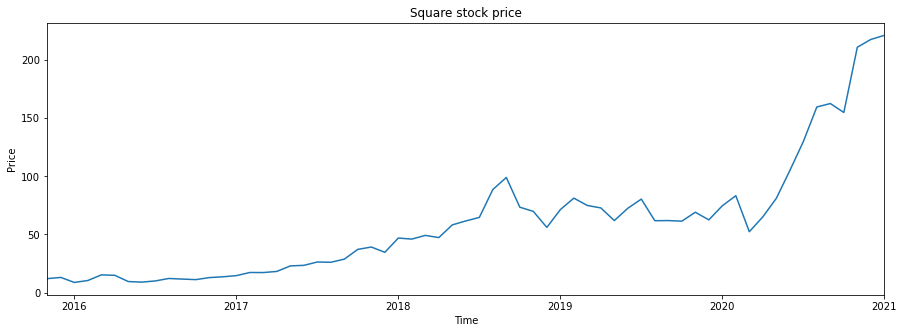

In [94]:
fig, ax= plt.subplots(figsize=(15,5))
square_cleaned_data['Close'].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Square stock price')
ax.set_xticks([], minor=True)
plt.show()

Square's stock price exhibit positive trend with huge growth in 2020.

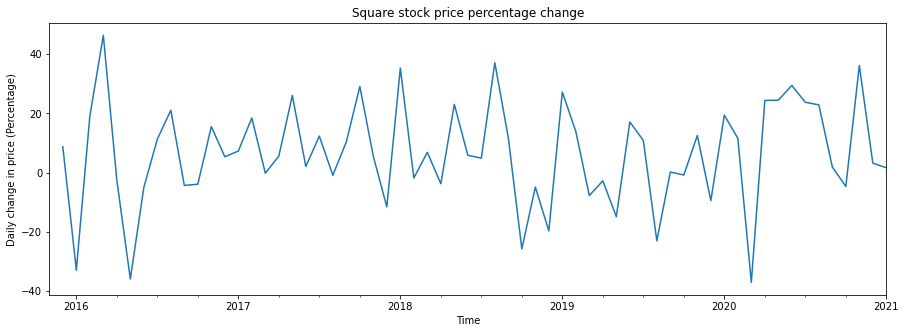

In [95]:
fig, ax= plt.subplots(figsize=(15,5))
(square_cleaned_data['Close'].pct_change()*100).plot()
ax.set_xlabel('Time')
ax.set_ylabel('Daily change in price (Percentage)')
ax.set_title('Square stock price percentage change')
plt.show()

Square's stock price have been more volatile in 2020.

In [96]:
square_cleaned_data['Close']

Date
2015-11-01     12.040000
2015-12-01     13.090000
2016-01-01      8.770000
2016-02-01     10.440000
2016-03-01     15.280000
                 ...    
2020-09-01    162.550003
2020-10-01    154.880005
2020-11-01    210.960007
2020-12-01    217.639999
2021-01-01    221.160004
Name: Close, Length: 63, dtype: float64

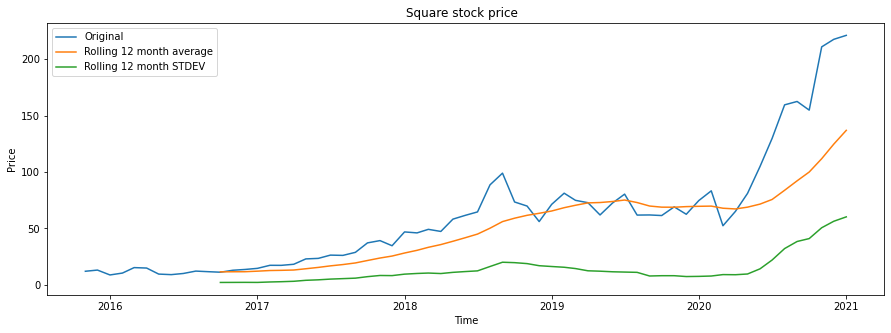

In [97]:
stationarity_plot(square_cleaned_data)

Rolling average is not constant, however, variance is relatively constant, except for 2020 period. Thus, differencing is required to make data stationary.

### 3.3 Time Series Decomposition

#### 3.3.1 Additive

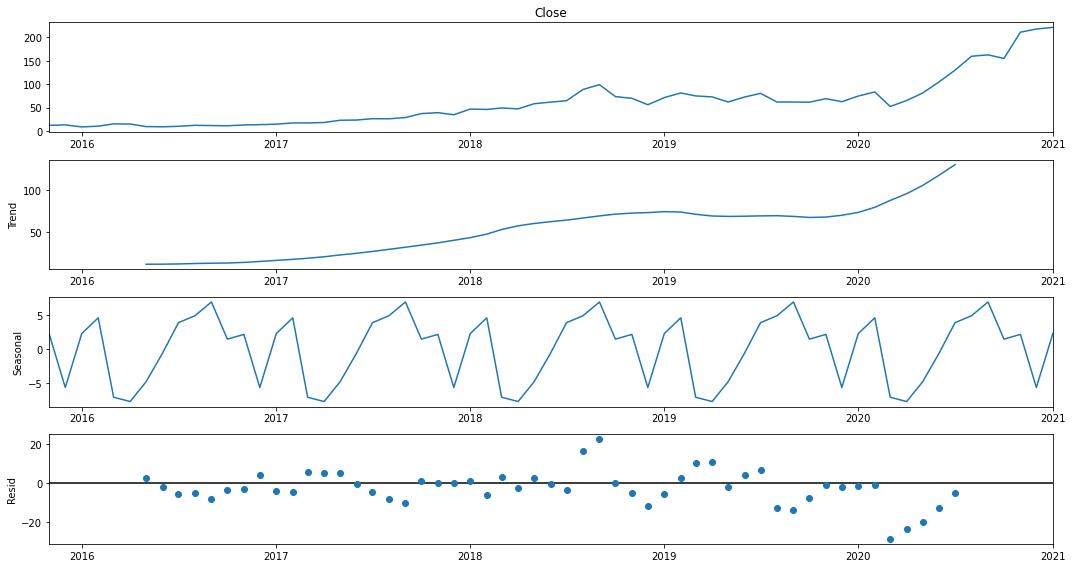

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(square_cleaned_data['Close'], model='additive', period=12)
plt.rcParams['figure.figsize'] = [15, 8]
result.plot()
plt.show()

#### 3.3.2 Multiplicative

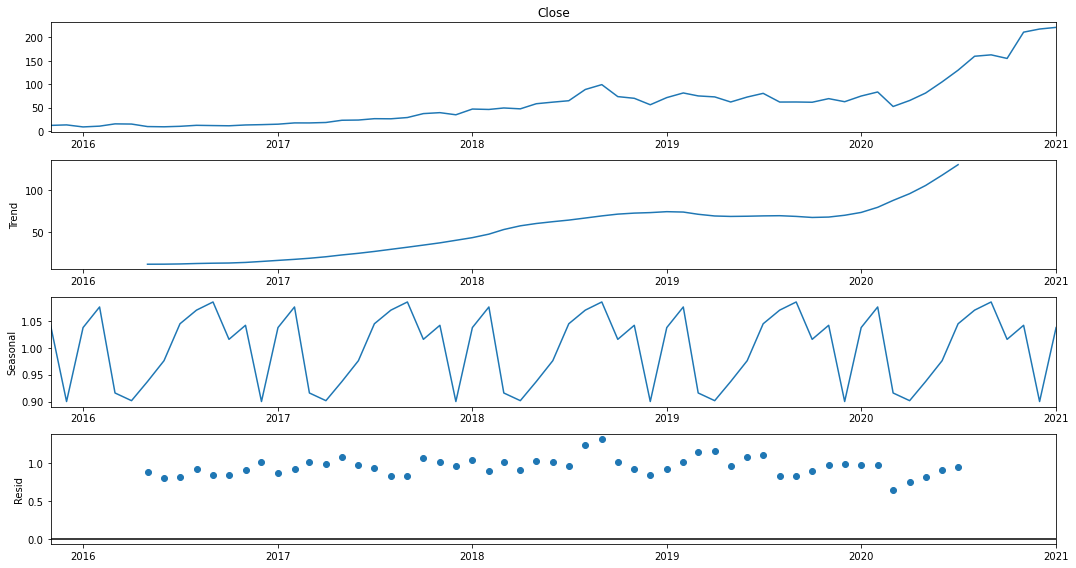

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(square_cleaned_data['Close'], model='multiplicative', period=12)
plt.rcParams['figure.figsize'] = [15, 8]
result.plot()
plt.show()

Multiplicative is able to capture variance of time series better, as seen in latter part of 2020 residuals. For additive, errors varies with time more, thus, multiplicative will capture time series decomposition better.

Seasonality is prevalent in data, where its impact is lowest in beginning of year and peaks in mid year.

### 3.4 Hypothesis Testing for stationarity

#### 3.4.1 ADF test

In [19]:
result = adfuller(square_cleaned_data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.607602
p-value: 0.997880


Since p-value > 0.05, we do not reject null hypothesis. Thus, there is a unit root.

#### 3.4.2 KPSS test

In [20]:
statistic, p_value, n_lags, critical_values = kpss(square_cleaned_data['Close'])
# Format Output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')

KPSS Statistic: 0.6045296331164681
p-value: 0.022224578807593806


Since p-value < 0.05, we reject null hypothesis. Thus, data is not stationary.

### 3.5 Autocorrelation and partial auto correlation

In [21]:
def acf_pacf_plot(df, order="", transformation=""):
    plt.rcParams['figure.figsize'] = [15, 4]
    auto_title = "Autocorrelation {} {}".format(order, transformation)
    plot_acf(df.dropna(), title=auto_title)
    plt.show()
    
    pauto_title = "Partial Autocorrelation {} {}".format(order, transformation)
    plot_pacf(df.dropna(), title=pauto_title)
    plt.show()

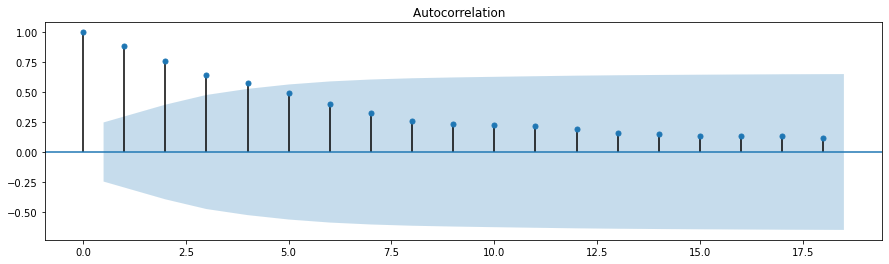

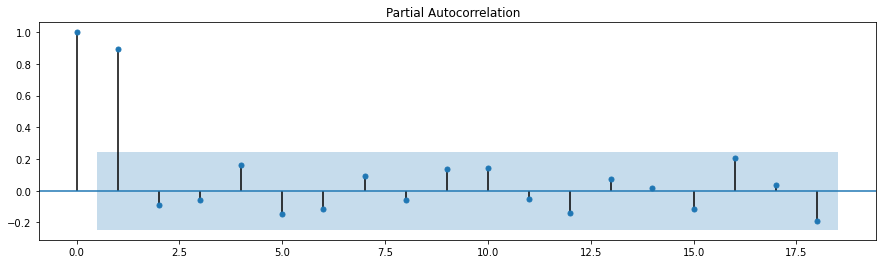

In [22]:
acf_pacf_plot(square_cleaned_data)

Autocorrelation does not fall immediately, suggesting that differencing is required.

# 4. Feature Engineering

### 4.1 Log Transformation

In [24]:
square_cleaned_data_log = np.log(square_cleaned_data)

In [25]:
square_cleaned_data_log.tail()

,Close
Date,
2020-09-01,5.090986
2020-10-01,5.042651
2020-11-01,5.351669
2020-12-01,5.382842
2021-01-01,5.398886


In [26]:
square_cleaned_data.tail()

,Close
Date,
2020-09-01,162.550003
2020-10-01,154.880005
2020-11-01,210.960007
2020-12-01,217.639999
2021-01-01,221.160004


### 4.2 Differencing

In [27]:
def first_order_differencing(df):
    first_order_df = df.diff()
    return first_order_df

In [28]:
def second_order_differencing(df):
    second_order_df = df.diff(2)
    return second_order_df

#### 4.2.1 Differencing for Original Data

In [29]:
square_cleaned_data_first_order = first_order_differencing(square_cleaned_data)
square_cleaned_data_second_order = second_order_differencing(square_cleaned_data)

In [30]:
square_cleaned_data_first_order.head()

,Close
Date,
2015-11-01,NaN
2015-12-01,1.05
2016-01-01,-4.32
2016-02-01,1.67
2016-03-01,4.84


In [31]:
square_cleaned_data_second_order.head()

,Close
Date,
2015-11-01,NaN
2015-12-01,NaN
2016-01-01,-3.27
2016-02-01,-2.65
2016-03-01,6.51


#### 4.2.2 Differencing for Log Transformed Data

In [32]:
square_cleaned_data_log_first_order = first_order_differencing(square_cleaned_data_log)
square_cleaned_data_log_second_order = second_order_differencing(square_cleaned_data_log)

In [33]:
square_cleaned_data_log_first_order.head()

,Close
Date,
2015-11-01,NaN
2015-12-01,0.083614
2016-01-01,-0.400512
2016-02-01,0.174308
2016-03-01,0.380900


In [34]:
square_cleaned_data_log_second_order.head()

,Close
Date,
2015-11-01,NaN
2015-12-01,NaN
2016-01-01,-0.316898
2016-02-01,-0.226204
2016-03-01,0.555208


### 4.3 Stationarity Comparison

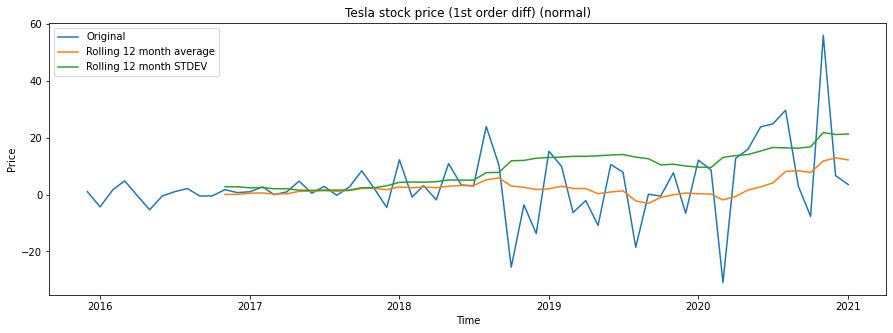

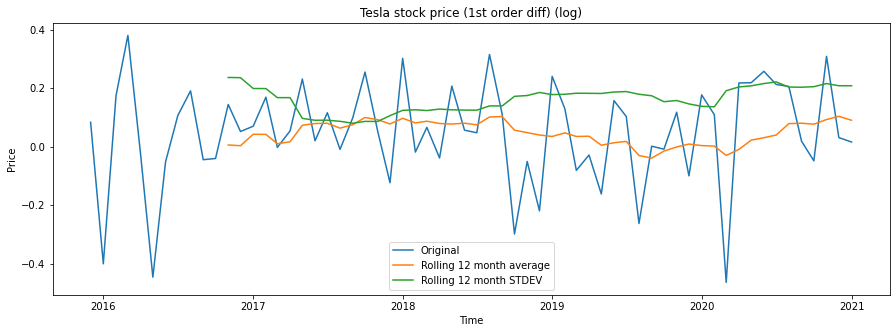

In [35]:
stationarity_plot(square_cleaned_data_first_order, "(1st order diff)", "(normal)")
stationarity_plot(square_cleaned_data_log_first_order, "(1st order diff)", "(log)")

Log transformation with 1st order difference exhibits the most stationarity attributes out of all transformation.

### 4.4 Autocorrelation and Partial Autocorrelation

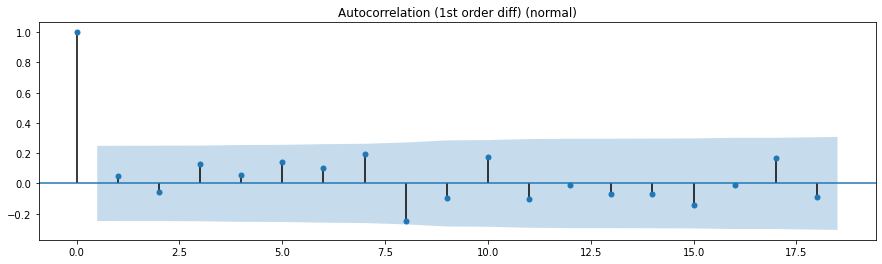

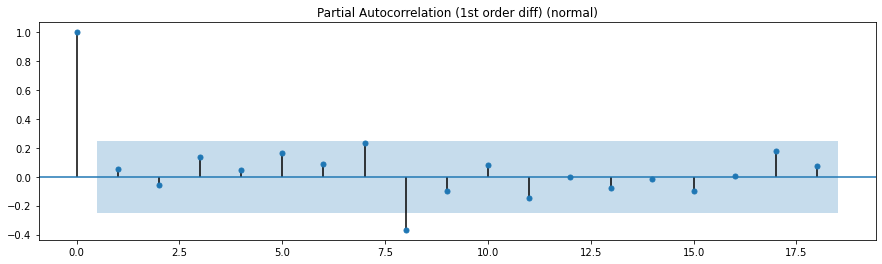

In [36]:
acf_pacf_plot(square_cleaned_data_first_order, "(1st order diff)", "(normal)")

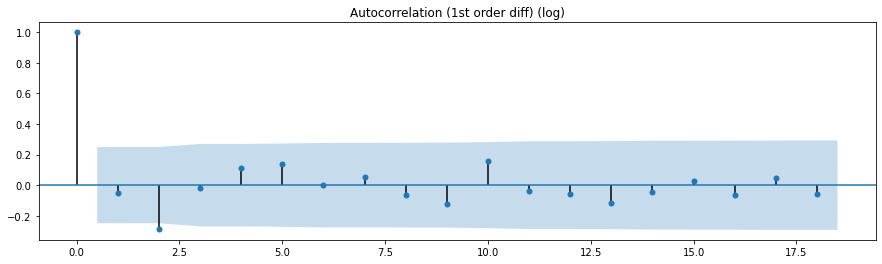

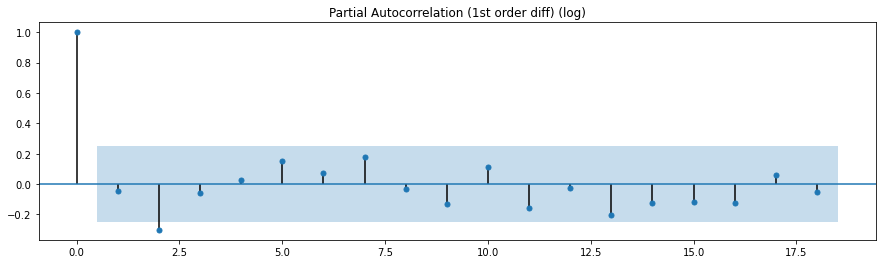

In [37]:
acf_pacf_plot(square_cleaned_data_log_first_order, "(1st order diff)", "(log)")

Log transformation with 1st order difference exhibits autocorrelation and partial autocorrelation that aligns with theory.

# 5. Forecasting

### 5.1 Split into Training and Validation Set

In [38]:
def split_training_validation(df, training_pct=0.8):
    y = df['Close'].dropna()
    training_size = int(len(y)*training_pct)
    validation_size = len(y) - training_size
    train = y.iloc[0:training_size]
    validation = y.iloc[training_size:]
    return y, train, validation

In [98]:
def training_validation_plot(train, validation, transformation=""):
    fig, ax= plt.subplots(figsize=(15,5))
    train.plot(label='Training')
    validation.plot(label='Validation')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Square stock price {}'.format(transformation))
    plt.legend(loc='best')
    plt.show()

#### 5.1.1 Split for Original Data

In [40]:
y, train, validation = split_training_validation(square_cleaned_data, training_pct=0.8)

In [42]:
train.tail()

Date
2019-08-01    61.840000
2019-09-01    61.950001
2019-10-01    61.430000
2019-11-01    69.120003
2019-12-01    62.560001
Name: Close, dtype: float64

In [43]:
validation.tail()

Date
2020-09-01    162.550003
2020-10-01    154.880005
2020-11-01    210.960007
2020-12-01    217.639999
2021-01-01    221.160004
Name: Close, dtype: float64

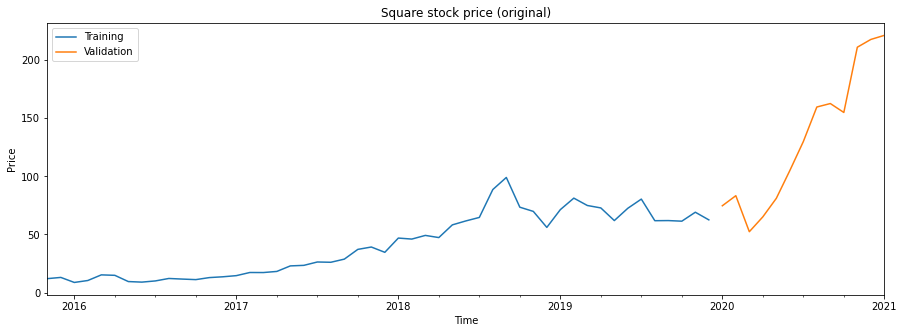

In [99]:
training_validation_plot(train, validation, "(original)")

#### 5.1.2 Split for Log Data

In [45]:
y_log, train_log, validation_log = split_training_validation(square_cleaned_data_log, training_pct=0.8)

In [46]:
train_log.tail()

Date
2019-08-01    4.124550
2019-09-01    4.126328
2019-10-01    4.117898
2019-11-01    4.235844
2019-12-01    4.136126
Name: Close, dtype: float64

In [47]:
validation_log.tail()

Date
2020-09-01    5.090986
2020-10-01    5.042651
2020-11-01    5.351669
2020-12-01    5.382842
2021-01-01    5.398886
Name: Close, dtype: float64

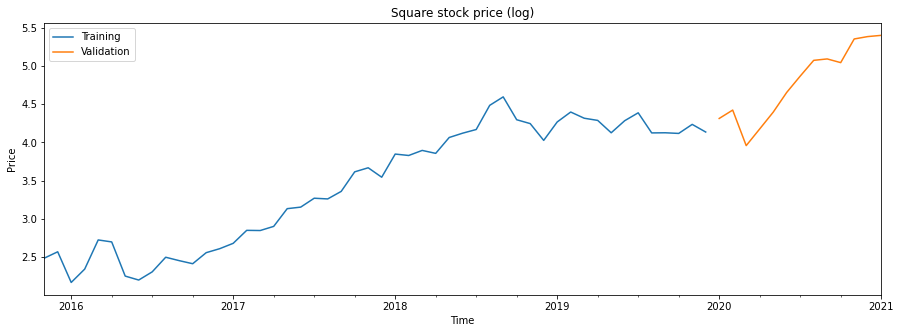

In [100]:
training_validation_plot(train_log, validation_log, "(log)")

### 5.2 Arima

#### 5.2.1 Forecast Original Observation

In [49]:
def arima_cross_validation(y, train, validation, configs):
    start = y.index.get_loc(validation.index[0])
    
    arima_preds = {}
    for config in configs:
        if config not in arima_preds:
            arima_preds[config] = []
    
    for config in configs:
        for i in range(start, len(y)):
            model = ARIMA(y_log.iloc[:i], order=config)
            fitted_model = model.fit(disp=-1)
            output = fitted_model.forecast(steps=1)
            y_hat = output[0][0]
            arima_preds[config].append(y_hat)
        
    return arima_preds

In [50]:
def convert_prediction_to_time_series(dic, series):
    dic_series = {}
    for key in dic:
        if key not in dic_series:
            dic_series[key] = pd.Series(dic[key], index=series.index)
    return dic_series

In [51]:
def time_series_exponential_transformation(dic):
    dic_exp = {}
    for key in dic:
        if key not in dic_exp:
            dic_exp[key] = np.exp(dic[key])
    
    return dic_exp

In [52]:
configs = [(3,1,2), (3,1,3)]
arima_preds = arima_cross_validation(y_log, train_log, validation_log, configs)

In [53]:
arima_series = convert_prediction_to_time_series(arima_preds, validation)
arima_back_transformed = time_series_exponential_transformation(arima_series)

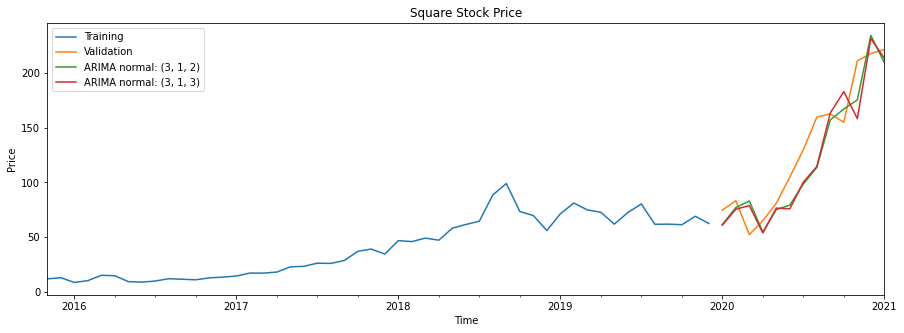

In [54]:
fig, ax= plt.subplots(figsize=(15,5))
train.plot(label='Training')
validation.plot(label='Validation')
for key in arima_back_transformed:
    arima_back_transformed[key].plot(label="ARIMA normal: {}".format(key))
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Square Stock Price')
plt.legend(loc='best')
plt.show()

#### 5.2.2 Model Validation

In [55]:
def model_performance_metrics(fitted, actual, train, name):
    table = pd.DataFrame()
    
    #rmse and se
    y = np.array((np.ravel(actual)-np.ravel(fitted))**2)
    y_sum = np.sum(y)
    n = len(y)

    resample = np.sqrt((y_sum-y)/(n-1))

    rmse = np.sqrt(y_sum/n)
    se = np.sqrt((n-1)*np.var(resample))
    
    #mape
    y_true = np.array(actual)
    y_pred = np.array(fitted)
    percentage = np.abs((y_true - y_pred) / y_true) * 100
    mape = np.mean(percentage)
    
    #MASE
    d = np.abs(np.diff(train)).sum()/(n-1)
    
    errors = np.abs(actual - fitted)
    mase = errors.mean()/d
    
    table['MASE'] = [mase]
    table['MAPE'] = [mape]
    table['RMSE'] = [rmse]
    table['SE'] = [se]
    table.index = [name]
    return table.round(4)

In [56]:
model_1_perf = model_performance_metrics(arima_back_transformed[(3,1,2)], validation, train, "Model 1")
model_2_perf = model_performance_metrics(arima_back_transformed[(3,1,3)], validation, train, "Model 2")

In [57]:
model_results = pd.concat([model_1_perf, model_2_perf])
model_results

,MASE,MAPE,RMSE,SE
Model 1,0.8749,17.3107,23.0217,3.9445
Model 2,0.9449,17.9393,25.8178,4.8016


ARIMA (3,1,2) (Model 1) has the best cross validation performance for ARIMA models.

#### 5.2.3 Model Diagnostic

In [58]:
def forecast_model_diagnostic(resid):
    #residual plot
    fig, ax= plt.subplots(figsize=(8,5))
    resid.plot()
    ax.set_xlabel('')
    ax.set_xticks([], minor=True) 
    ax.set_title('Residual plot')
    sns.despine()
    plt.show()
    
    #autocorrelation plot
    fig, ax = plt.subplots(figsize=(8,5))
    sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax)
    sns.despine()
    plt.show()
    
    #residual distribution plot
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(resid)
    ax.set_title('Residual distribution plot')
    ax.set_ylabel('Density')
    ax.set_xlabel('Residual')
    plt.show()

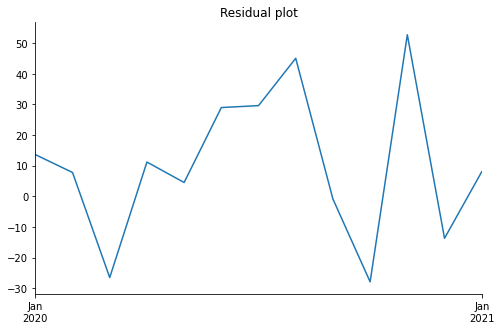

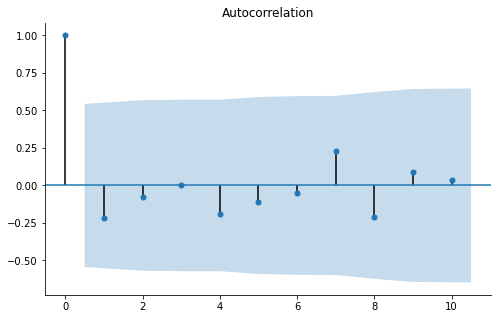

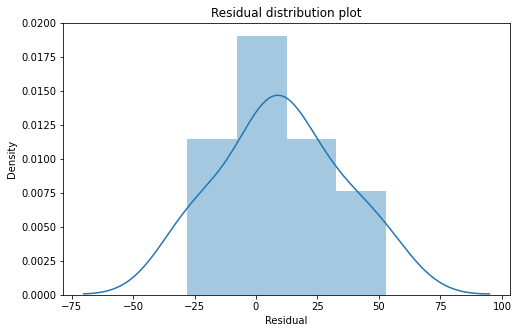

In [59]:
resid_arima = validation - arima_back_transformed[(3,1,3)]
forecast_model_diagnostic(resid_arima)

Residuals exhibit white noise process, however, residuals are more volatile in mid 2020. This can be attributed to market uncertainty due to coronavirus.

#### 5.2.5 Forecast Next 24 Months

In [60]:
model = ARIMA(y_log, order=(3,1,2))
fitted_model = model.fit(disp=-1)
output = fitted_model.forecast(steps=24)
y_hat_final = output[0]

In [61]:
forecast__arima_index = pd.date_range(start='1/2/2021', periods=24, freq='MS')
forecast_arima_24 = pd.Series(y_hat_final, index=forecast__arima_index)
forecast_arima_24_back_transformed = np.exp(forecast_arima_24)

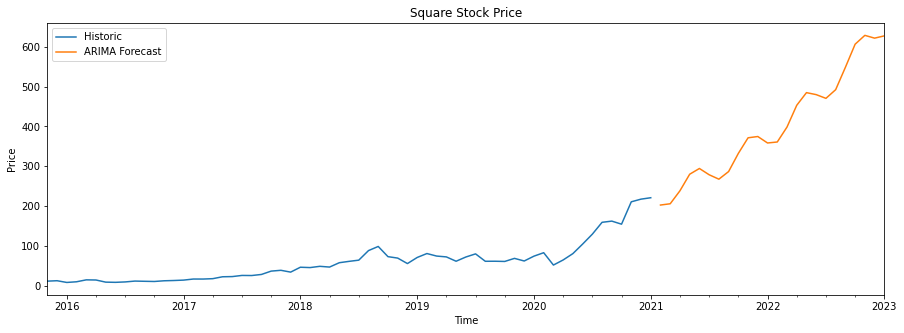

In [62]:
fig, ax= plt.subplots(figsize=(15,5))
y.plot(label='Historic')
forecast_arima_24_back_transformed.plot(label="ARIMA Forecast")
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Square Stock Price')
plt.legend(loc='best')
plt.show()

### 5.3 Holt Winters Exponential Smoothing

#### 5.3.1 Forecast Observations

In [101]:
def forecast_observation(train, validation, fitted, name):
    fig, ax= plt.subplots(figsize=(15,5))
    train.plot(label='Training')
    validation.plot(label='Validation')
    fitted.plot(label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Square Stock Price')
    plt.legend(loc='best')
    plt.show()

In [102]:
def holt_winters_cross_validation(y, validation, configs):
    start = y.index.get_loc(validation.index[0])
    
    hw_preds = {}
    for config in configs:
        pred_hw = []
        for i in range(start, len(y)):
            model = forecast.holtwinters(y.iloc[:i], additive=config[0], damped=config[1], m=12)
            model.fit()
            pred_hw.append(model.forecast(1)[0])
            
        hw_preds[tuple(config)] = pred_hw
        
    return hw_preds

In [103]:
configs = [
    [True, True],
    [True, False],
    [False, True],
    [False, False],
]
hw_preds = holt_winters_cross_validation(y, validation, configs)

In [104]:
hw_series = convert_prediction_to_time_series(hw_preds, validation)

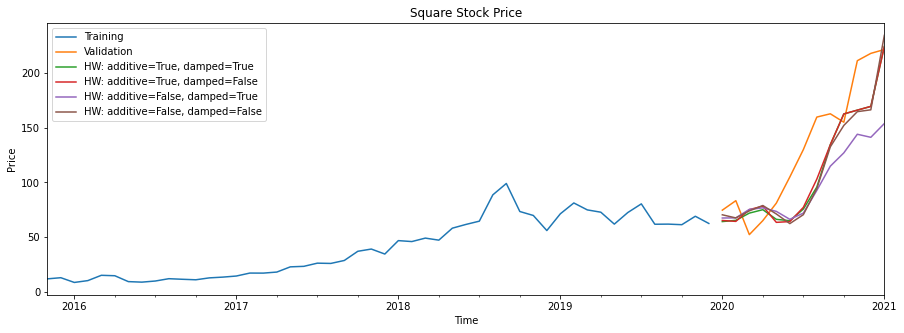

In [105]:
fig, ax= plt.subplots(figsize=(15,5))
train.plot(label='Training')
validation.plot(label='Validation')
for key in hw_series:
    hw_series[key].plot(label="HW: additive={}, damped={}".format(key[0], key[1]))
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Square Stock Price')
plt.legend(loc='best')
plt.show()

#### 5.3.2 Model Validation

In [70]:
df_ls = []
for i in range(len(configs)):
    model_perf = model_performance_metrics(hw_series[tuple(configs[i])], validation, train, 
                                           "Model {} ({})".format(i+3, configs[i]))
    df_ls.append(model_perf)

In [71]:
model_results = pd.concat(df_ls)
model_results

,MASE,MAPE,RMSE,SE
"Model 3 ([True, True])",1.2655,22.5541,33.9300,5.5615
"Model 4 ([True, False])",1.2692,23.2643,33.1662,4.8559
"Model 5 ([False, True])",1.7984,28.2805,46.6586,6.3241
"Model 6 ([False, False])",1.3129,22.9335,35.6001,5.8194


Additive Holt Winters without damping is chosen. This is primarily due to additive model describing time series better, as seen in time series decomposition. Model 4 has the best cross validation out of all additive models (i.e. model 4).

#### 5.3.3 Model Diagnostic

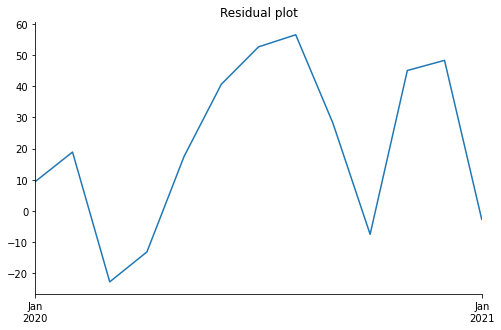

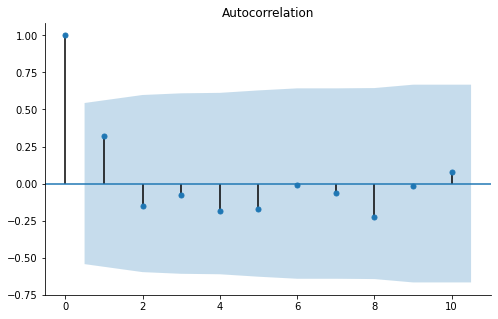

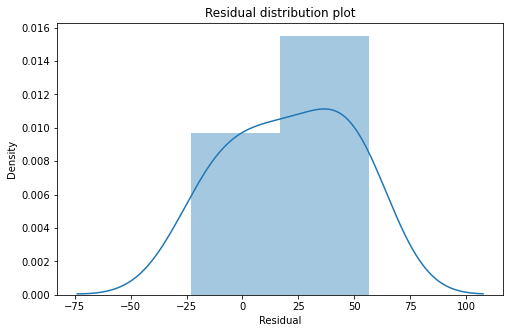

In [73]:
resid_hw = validation - hw_series[tuple(configs[1])]
forecast_model_diagnostic(resid_hw)

Residuals also show white noise process for model 5, with volatile residuals in 2020.

#### 5.3.4 Forecast Next 24 Months

In [106]:
def forecast_observation_variant(y, fitted, name):
    fig, ax= plt.subplots(figsize=(15,5))
    y.plot(label='Observed')
    fitted.plot(label=name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Square Stock Price')
    plt.legend(loc='best')
    plt.show()

In [107]:
h=24
mhw=forecast.holtwinters(y, additive=True, damped=False, m=12)
mhw.fit()
print('alpha: {:.4f}'.format(mhw.alpha))
print('beta: {:.4f}'.format(mhw.beta))
print('delta: {:.4f}'.format(mhw.delta))
mhw.summary()
forecast_mhw_index = pd.period_range(start="2021-02-01", periods=h, freq='M')
forecast_hw = pd.Series(mhw.forecast(h), index=forecast_mhw_index)

alpha: 0.8517
beta: 0.1295
delta: 1.0000
 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.852 (0.192)
 beta  (trend)    0.130 (0.150)
 delta (seasonal) 1.000 (0.575)
 
 In-sample fit:
 MSE               205.096
 RMSE              14.321
 Log-likelihood   -257.083
 AIC               522.165
 BIC               530.738


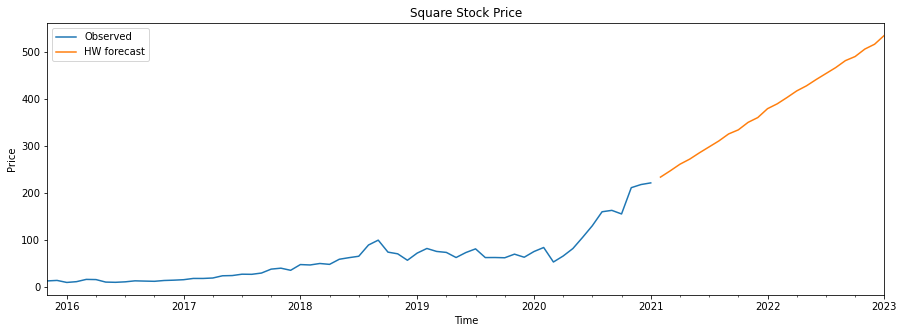

In [108]:
forecast_observation_variant(y, forecast_hw, 'HW forecast')

# 6. Results

### 6.1 Model Comparison

In [78]:
final_results = pd.concat([model_1_perf, df_ls[1]])
final_results

,MASE,MAPE,RMSE,SE
Model 1,0.8749,17.3107,23.0217,3.9445
"Model 4 ([True, False])",1.2692,23.2643,33.1662,4.8559


ARIMA (3,1,2) has best cross validation performance out of all tested models, thus, it is used to build final forecasting model.

### 6.2 Final Forecast

In [79]:
def create_upper_lower_bound(mean, se, alpha):
    result = []
    p_value = (alpha+1) / 2
    z_score = stats.norm.ppf(p_value)
    
    for i in range(len(mean)):
        current_lower_upper = []
        error = se[i] * z_score
        current_lower_upper.append(mean[i]-error)
        current_lower_upper.append(mean[i]+error)
        
        result.append(current_lower_upper)
        
    return result

In [80]:
def create_conf_intv(arr, start_period, num_periods):
    lower_arr = [x[0] for x in arr]
    upper_arr = [x[1] for x in arr]

    forecast__index = pd.date_range(start=start_period, periods=num_periods, freq='MS')
    
    lower_intv = pd.Series(lower_arr, index=forecast__index)
    upper_intv = pd.Series(upper_arr, index=forecast__index)
    lower_intv_exp = np.exp(lower_intv)
    upper_intv_exp = np.exp(upper_intv)
    
    return pd.concat([lower_intv_exp, upper_intv_exp], axis=1)

In [87]:
def fanchart(y, forecast, intv1, alpha):
    fig, ax= plt.subplots(figsize=(15,5))
    first = forecast.iloc[:1]
    extended = y.append(first)
    ax.plot(extended, color='#D62728', label='Historic')
    ax.plot(forecast, color='black', alpha=0.6, label='ARIMA forecast (3,1,2)')
    ax.fill_between(forecast.index, intv1.iloc[:,0], 
                    intv1.iloc[:,1], facecolor='#FAB8A4', lw=0, 
                    label='{:.0f}% confidence interval'.format(alpha))
    ax.fill_betweenx(ax.get_ylim(), forecast.index[0], forecast.index[-1], facecolor='grey', alpha=0.15, 
                     label='Forecast Region')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Square Stock Price')
    plt.legend(loc='upper left')
    plt.show()

In [88]:
alpha = 0.5
conf_intv = create_upper_lower_bound(output[0], output[1], alpha)
intv1 = create_conf_intv(conf_intv, '1/1/2021', 24)

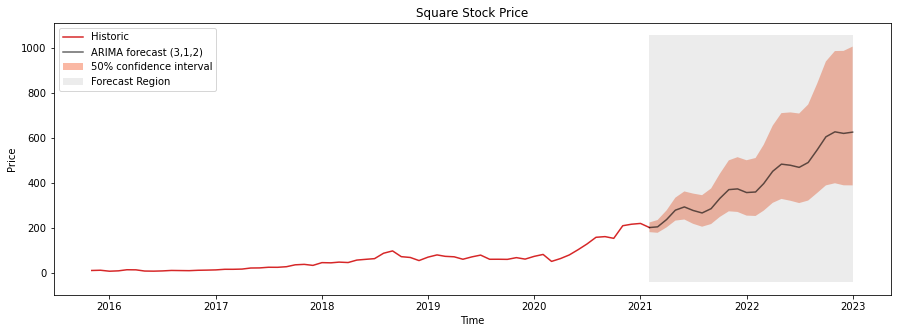

In [89]:
fanchart(y, forecast_arima_24_back_transformed, intv1, alpha*100)

# Future Development

Future study can be done on other factors that can impact on a company's stock price such as their financial performance, industry performance and economic condition. Building a multivariate forecasting model can better capture contributors to Square stock price and strengthen the performance of this forecasting model.

# Conclusion

In conclusion, ARIMA (3,1,2) has the best forecasting performance amongst all tested models and we can expect Square stock price to continue rising in the next 24 months.